# Практическое занятие

Для начала импорт основных инструментов

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd

Загружаем наш набор данных (предварительно нужно скачать с https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)

In [3]:
df = pd.read_csv("IMDB Dataset.csv")

Проверяем баланс данных

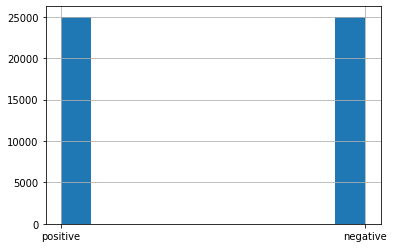

In [4]:
df["sentiment"].hist();

Отлично! Данные сбалансированы, то есть мы можем использовать любую метрику качества классификации, но мы, пожалуй, выберем ROC AUC.

Для удобства, преобразуем столбец с метками класса в бинарный признак, где 1 - это положительны отзыв, а 0 - это отрицательный. На всякий случай, положим результат этого преобразования в отдельный столбец

In [5]:
df["y"] = df["sentiment"].map({
    "positive": 1,
    "negative": 0,
})

df

,review,sentiment,y
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1
...,...,...,...
49995,I thought this movie did a down right good job...,positive,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,0
49997,I am a Catholic taught in parochial elementary...,negative,0
49998,I'm going to have to disagree with the previou...,negative,0


## Мешок слов

Теперь нам нужно сформировать мешок слов. Это можно сделать вручную

In [6]:
# Для начала сформировать словарь слов

d = {}

for document in df["review"]:
    # Разбиваем любым способом текст на токены
    tokens = document.lower().replace("<br>", "").split(" ")
    
    # И записываем токены в словарь
    for token in tokens:
        if token == "": continue
        if token in d:
            d[token] += 1 # заодно считаем, сколько раз слово встретилось на всем корпусе текстов
        else:
            d[token] = 1

In [7]:
# 200 самых популярных слов
popular_words = sorted(d, key=lambda x: d[x], reverse=True)
popular_words[:10]

['the', 'a', 'and', 'of', 'to', 'is', 'in', 'i', 'this', 'that']

По факту, нам стоило бы убрать мусор из текста, так как там иногда встречаются HTML-теги, это удобно делать с помощью регулярных выражений

In [8]:
import re

# Вот так можно было бы убрать HTML теги из текста
re.subn("<.*?>", "", "<b>Some Text<\b> <div> Block <b> bold text </dev>")

('Some Text  Block  bold text ', 5)

Дальше нужно запомнить позицию слова в словаре, чтобы зафиксировать за каждым элементом вектора в мешке слова конкретное слово 

In [9]:
# Можно это сделать на всем словаре
# vectorizer = {word: i for i, word in enumerate(d)}

# А можно только на самых популярных слова
vectorizer = {word: i for i, word in enumerate(popular_words)}

А теперь преобразуем

In [10]:
bows = [] # сюда будем складывать преобразованные тексты

for document in df["review"]:
    # Разбиваем любым способом текст на токены
    tokens = document.lower().replace("<br>", "").split(" ")
    
    # Формируем вектор из нулей с размером словаря
    bow = np.zeros(len(vectorizer))
    for token in tokens:
        # Пропускаем неизвестные слова
        if token not in vectorizer:
            continue
        bow[vectorizer[token]] += 1
    bows.append(bow)
            
    break # Ограничимся одной итерацией
    
bows

[array([15.,  3.,  6., ...,  0.,  0.,  0.])]

Это долгий путь, мы же выбираем SKLearn, так как там это сделали уже за нас

In [11]:
# Формируем мешок слов

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words="english", max_df=0.95, max_features=200)
X = vectorizer.fit_transform(df["review"])
X

<50000x200 sparse matrix of type '<class 'numpy.int64'>'
	with 1186760 stored elements in Compressed Sparse Row format>

In [12]:
# Выше мы видим, что получили разряженную матрицу, при небольшом количестве признаков
# чуть удобнее работать с плотной матрицей, в которую мы преобразуем (это не обязетельно делать!)
X = X.toarray()

In [79]:
tmp = X / (X*X).sum(axis=1,keepdims=True)
tmp[np.isnan(tmp)] = 0
tmp

<ipython-input-79-cc0a52cec55d>:1: RuntimeWarning: invalid value encountered in true_divide
  tmp = X / (X*X).sum(axis=1,keepdims=True)


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.025     ,
        0.025     ],
       ...,
       [0.        , 0.02083333, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [63]:
tmp = X / (X*X).sum(axis=1, keepdims=True)

<ipython-input-63-c5346547d9e7>:1: RuntimeWarning: invalid value encountered in true_divide
  tmp = X / (X*X).sum(axis=1, keepdims=True)


In [68]:
tmp[np.isnan(tmp)] = 0
tmp

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.025     ,
        0.025     ],
       ...,
       [0.        , 0.02083333, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

И выше мы совершили ошибку. Если мы используем данный объект для преобразования текста из обучающей выборки, то мы косвенным образом протащим информацию из тестовой. Это связано с тем, что для расчет частоты появления слова будут использованы все данные, даже те, что потом уйдут в тестовую выборку. **Так делать нельзя**

$$
|\vec{x}|^2 = \sum_{n} x_n^2
$$

In [33]:
tmp = X[0] / np.sqrt((X[0]*X[0]).sum())

(tmp*tmp).sum()

1.0

# Наконец классификация

In [14]:
# Положим метки класса в отдельную переменную для удобства
y = df["y"]
y

0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: y, Length: 50000, dtype: int64

Попробуем решить задачу в общем виде, чтобы потом это было удобно и компактно использовать на любых текстах. Первым шагом, разобъем наши тексты на две выборки (именно тексты)

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df["review"], df["y"], random_state=42)

In [16]:
X_train

27434    I figure this to be an "alternate reality" tee...
13400    This is the kind of movie that wants to be goo...
883      This was by far the worst movie I've ever seen...
7303     Awful, awful, awful...<br /><br />I loved the ...
45124    Fragile Carne, just before his great period. A...
                               ...                        
11284    `Shadow Magic' recaptures the joy and amazemen...
44732    I found this movie to be quite enjoyable and f...
38158    Avoid this one! It is a terrible movie. So wha...
860      This production was quite a surprise for me. I...
15795    This is a decent movie. Although little bit sh...
Name: review, Length: 37500, dtype: object

In [17]:
X_test

33553    I really liked this Summerslam due to the look...
9427     Not many television shows appeal to quite as m...
199      The film quickly gets to a major chase scene w...
12447    Jane Austen would definitely approve of this o...
39489    Expectations were somewhat high for me when I ...
                               ...                        
9771     First separate the story from the film. The st...
34737    The most obvious flaw...horrible, horrible scr...
30390    The brilliance of this movie is that even a co...
6797     Yaitate!! Japan is a really fun show and I rea...
37270    Wonderfully funny, awe-inspiring feature on th...
Name: review, Length: 12500, dtype: object

# Наивный Байес

Для унификации подхода, воспользуемся объектом **Pipeline**, который позволяет формировать конвейер для ваших данных.

In [105]:
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer

# Создаем конвейер
nb = make_pipeline(
    # Первый этап этого конвейера - это сформировать мешок слов из текста
    CountVectorizer(ngram_range=(1,1), stop_words="english", max_df=0.95, max_features=900),
    # Второй этап - взять этот мешок слов и отдать алгоритму машинного обучения
    ComplementNB(),
)

In [106]:
nb

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_df=0.95, max_features=900,
                                 stop_words='english')),
                ('complementnb', ComplementNB())])

In [107]:
# Этот конвейер ведет себя, как один цельный объект
# Мы можем его обучить, это обучит не только основной метод машинного обучения,
# Но и все промежуточные этапы (для нас это CountVectorizer)

nb.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_df=0.95, max_features=900,
                                 stop_words='english')),
                ('complementnb', ComplementNB())])

In [108]:
# А теперь мы можем легко это использовать для предсказания

y_pred = nb.predict_proba(X_test)[:, 1]

Осталось посмотреть на сколько хорошо справился наивный Байес

In [109]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_pred)

0.90017730901877

Теперь мы легко можем подсовывать нашей модели любой текст

In [104]:
nb.predict_proba([
    "It was really bad movie",
])

array([[0.96129192, 0.03870808]])

Отсюда видно, что текст больше плохой, чем хороший, значит его класс negative

# Подбор параметров

Выше если перебирать различное число максимально популярных слова, мы сможем увидеть, что чем больше слов, тем лучше предсказание. В ручную перебирать - нам лень. Мы можем использовать GridSearchCV для этого

In [24]:
from sklearn.model_selection import GridSearchCV

# Обратите внимание, что я обращаются к параметрам
# этапа конвейера через его имя, двойную черту снизу и имя нужного параметра

params = {
    "countvectorizer__max_features": [200, 500, 700, 900]
}

cv = GridSearchCV(nb, params, scoring="roc_auc")
cv.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(max_df=0.95,
                                                        max_features=700,
                                                        stop_words='english')),
                                       ('complementnb', ComplementNB())]),
             param_grid={'countvectorizer__max_features': [200, 500, 700, 900]},
             scoring='roc_auc')

Осталось посмотреть на победителя

In [25]:
cv.best_params_

{'countvectorizer__max_features': 900}

In [26]:
cv.best_score_

0.8982499564960506

Это было получено с помощью кросс-валидации на обучающей выборке, можем сравнить результат с тестовой

In [27]:
roc_auc_score(y_test, cv.best_estimator_.predict_proba(X_test)[:, 1])

0.90017730901877

# kNN

Для метода ближайших соседей все в целом точно также проходит

In [69]:
from sklearn.base import TransformerMixin, BaseEstimator

class NormTransformer(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.toarray()
        norm = np.sqrt( (X*X).sum(axis=1, keepdims=True) )
        X = X / norm
        
        mask = np.isnan(X)
        X[mask] = 0
        
        return X
        

In [81]:
from sklearn.neighbors import KNeighborsClassifier


knn = make_pipeline(
    CountVectorizer(stop_words="english", max_df=0.95, max_features=700),
    NormTransformer(),
    KNeighborsClassifier(n_neighbors=11),
)
knn.fit(X_train, y_train)
roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1])

<ipython-input-69-9f0e0e32b81a>:13: RuntimeWarning: invalid value encountered in true_divide
  X = X / norm


0.742028129313035

In [80]:
knn

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_df=0.95, max_features=700,
                                 stop_words='english')),
                ('normtransformer', NormTransformer()),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [30]:
params = {
    "countvectorizer__max_features": [200, 500, 700, 900],
    "kneighborsclassifier__n_neighbors": [3, 5, 7, 9, 11, 13],
}

cv = GridSearchCV(knn, params, scoring="roc_auc")
cv.fit(X_train, y_train)

KeyboardInterrupt: 

# Деревья решений

In [84]:
from sklearn.tree import DecisionTreeClassifier

dt = make_pipeline(
    CountVectorizer(stop_words="english", max_df=0.95, max_features=700),
    DecisionTreeClassifier(max_depth=10),
)
dt.fit(X_train, y_train)
roc_auc_score(y_test, dt.predict_proba(X_test)[:, 1])

0.7844361366565362

In [85]:
dt

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_df=0.95, max_features=700,
                                 stop_words='english')),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=10))])

In [91]:
params = {
    "countvectorizer__max_features": [900],
    "decisiontreeclassifier__max_depth": [5, 10, 15, 25, 30],
}

cv = GridSearchCV(dt, params, scoring="roc_auc")
cv.fit(X_train, y_train)

KeyboardInterrupt: 

# Линейные модели

In [89]:
from sklearn.linear_model import LogisticRegression

lr = make_pipeline(
    CountVectorizer(stop_words="english", max_df=0.95, max_features=900),
    LogisticRegression(C=0.01),
)
lr.fit(X_train, y_train)
roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1])

0.9313214463792572

In [ ]:
params = {
    "countvectorizer__max_features": [800, 900],
    "logisticregression__C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
}

cv = GridSearchCV(lr, params, scoring="roc_auc")
cv.fit(X_train, y_train)

# Random Forest

In [93]:
from sklearn.ensemble import RandomForestClassifier

rf = make_pipeline(
    CountVectorizer(stop_words="english", max_df=0.95, max_features=900),
    RandomForestClassifier(n_estimators=100, ),
)
rf.fit(X_train, y_train)
roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])

0.9073352074805632

In [ ]:
rf

In [ ]:
params = {
    "countvectorizer__max_features": [800, 900],
    "randomforestclassifier__n_estimators": [100, 200, 300, 400],
}

cv = GridSearchCV(rf, params, scoring="roc_auc")
cv.fit(X_train, y_train)

# Stacking

In [110]:
from sklearn.ensemble import StackingClassifier

estimators = [
    ("nb", nb),
    ("knn", knn),
    ("dt", dt),
    ("lr", lr),
    ("rf", rf)
]

sc = StackingClassifier(
    estimators=estimators,
    cv=2,
)

sc.fit(X_train, y_train)
roc_auc_score(y_test, sc.predict_proba(X_test)[:, 1])

<ipython-input-69-9f0e0e32b81a>:13: RuntimeWarning: invalid value encountered in true_divide
  X = X / norm
<ipython-input-69-9f0e0e32b81a>:13: RuntimeWarning: invalid value encountered in true_divide
  X = X / norm
<ipython-input-69-9f0e0e32b81a>:13: RuntimeWarning: invalid value encountered in true_divide
  X = X / norm


0.9365223675380951